<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 22px; height: 55px; width: 55px">

# GA Capstone: Spotify Playlist Generator
<br>
This project aims to create a spotify playlist generator that can sequence songs from a seed playlist following a mood vector. Feel free to reference my code, but be sure to make reference to it in your own!  

This project has taken inspiration from the following other sources:
1. [Cameron Watts][1]: Extracting Song Data from the Spotify API using Python
2. [Raymond Cheng][2]: Build a Song Recommendation System Using Streamlit and Deploy on Heroku
3. [chorgan182][3]: chorgan182's Playlist Preserver
4. [Karina Kong][4]: Spotify Music Recommender
5. [Zachary Lim][5]: Flask Spotify Plotly Template
6. [Perelin][6]: Simple demo for spotipy OAuth workflow

[1]:https://towardsdatascience.com/extracting-song-data-from-the-spotify-api-using-python-b1e79388d50
[2]:https://towardsdatascience.com/build-a-song-recommendation-system-using-streamlit-and-deploy-on-heroku-375a57ce5e85
[3]:https://github.com/chorgan182/PlaylistPreserver
[4]:https://github.com/karinakong/young_grasshopper/tree/main/spotify_music_recommender
[5]:https://github.com/zachlim98/Flask-Spotify-Plotly
[6]:https://github.com/perelin/spotipy_oauth_demo

## Background of Music, Spotify
Spotify's role in the music industry needs no introduction - founded in 2006, it is a company that has become entrenched in how most people browse, discover, and enjoy music, both new and old. Initially meant as an answer to yester-decade's music file-sharing piracy issues, it now boasts over 450 million active users, with just under 200 million of them paid subscribers of the platform, and beating out its competition for market share that popped up in its wake, such as Apple Music, Youtube Music, and Amazon. 

For a more recent summary about Spotify, you may read [CNBC's recent commentary here](https://www.cnbc.com/2022/11/10/how-spotify-stayed-no-1-in-streaming-music-vs-apple-youtube-amazon.html).

Since its inception, the company has not been without controversy, bumping heads with the likes of industry giants like Taylor Swift and more recently Neil Young, about the platform's meager royalty payment terms and other socio-political issues. Still, the company remains largely a staple in the world of music, and has made listening to music that much more accessible for the average consumer.

## Project Statement
Spotify already has a robust recommendation system, and this usually comes in the form of procedurally generated, user-tailored playlists to a person's taste. 

But this comes with a catch.

Spotify likes to recommend you songs that are new, and keep you listening and discovering new music. While this is a great way to find 'new digs', it does not allow you to intuitively create playlists from a known pool of songs - say for example from your saved songs. 

**The solution**: To create a playlist recommender that operates from **within** a given song pool, say from an existing playlist, or from a user's liked songs.

### Importing Packages

In [1]:
# Essential Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Spotify API packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

# For calculation and model application
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Miscellaneous
import time, datetime

In [2]:
# !pip install spotipy

In [3]:
# Switch to control scrape
run_scrape = False

### Setting Spotify Credentials

In [50]:
# import secrets from streamlit deployment
cid = '[CLIENT-SECRET-ID]' # Replace with app client id
skey = '[CLIENT-SECRET-KEY]' # Replace with app secret key
uri = '[REDIRECT-URI]' # Replace with app redirect url

# set scope and establish connection
scopes = " ".join(["user-read-private",
                   "playlist-read-private",
                   "playlist-modify-private",
                   "playlist-modify-public",
                   "user-read-recently-played"
                  ])

# 0Auth object definition
oauth = SpotifyOAuth(scope=scopes,
                     redirect_uri=uri,
                     client_id=cid,
                     client_secret=skey,
                     cache_path='.spotipyoauthcache')

In [5]:
# Instantiate spotipy object
sp = spotipy.Spotify(auth_manager=oauth)

### Functions

In [6]:
# Format Genre Output
def format_genre(genre_dict,artists_uri):
    genre_set = []
    for j in range(len(artists_uri)):
        genre_tmp = [genre_dict[artists_uri[j][i]] for i in range(len(artists_uri[j]))]
        genre_tmp = np.unique([x for y in genre_tmp for x in y])
        genre_set.append(genre_tmp)
    
    return genre_set

In [7]:
# Genre, Explicity, and Availability commented out until can fix spotify API
def get_track_details(source,sample,market=None):
    
    # |-Get track, artist, and album names-|
    track_name = [source['items'][track]['track']['name'] for track in range(sample)]
    album_name = [source['items'][track]['track']['album']['name'] for track in range(sample)]
    
    # |-Artists information----------------|
    artists_list = [source['items'][track]['track']['artists'] for track in range(sample)]
    artists_name = [[artists_list[track][artist]['name'] 
                     for artist in range(len(artists_list[track]))] for track in range(len(artists_list))]
    
    # |-Get corresponding URIs-------------|
    track_uri = [source['items'][track]['track']['uri'] for track in range(sample)]
    album_uri = [source['items'][track]['track']['album']['uri'] for track in range(sample)]
    
    # |-Artists URIs-----------------------|
    artists_uri = [[artists_list[track][artist]['uri'] 
                    for artist in range(len(artists_list[track]))] for track in range(len(artists_list))]

    # |-Other Metrics----------------------|
    track_pop = [source['items'][track]['track']['popularity'] for track in range(sample)] # Popularity Index
    track_expl = [source['items'][track]['track']['explicit'] for track in range(sample)] # Explicity Index
    if market != None: track_play = [source['items'][track]['track']['is_playable'] 
                                     for track in range(sample)] # Playability Index
    else: track_play = [True for track in range(sample)]

    # |-Get track audio features-----------|
    audio_feat_raw = sp.audio_features(track_uri)
    audio_features = [audio_feat_raw[i] for i in range(sample)]
    
    # |-Associated genres of artists-------|
    # 1. Get full list of artists in 1 continuous list
    artists_uri_condensed = [artists_list[i][j]['uri'] for i in range(len(artists_list)) 
                             for j in range(len(artists_list[i]))]
    
    # 2. Get details of associated artists based on the subset of tracks from scrape
    genre_raw = sp.artists(np.unique(artists_uri_condensed))
    
    # 3. Create dictionary of artist to associated genres
    genre_dict = {genre_raw['artists'][i]['uri']:genre_raw['artists'][i]['genres'] 
                  for i in range(len(genre_raw['artists']))}
    
    # 4. Combine each list of unique genres from each of associated artists
    artists_genres = format_genre(genre_dict,artists_uri)
    
    
    # |-Intermediary DataFrames------------|
    track_details = pd.DataFrame(list(zip(track_name,artists_name,album_name,
                                          artists_genres,
                                          track_pop,
                                          track_expl,track_play
                                         )), 
                                 columns=['Name','Artist','Album',
                                          'Genres',
                                          'Popularity',
                                          'Explicit','Available'
                                         ])
    audio_details = pd.DataFrame(audio_features)
    track_uris = pd.DataFrame(list(zip(track_uri,artists_uri,album_uri)), columns=['track_uri','artist_uri','album_uri'])

    # |-Combine dataframe outputs----------|
    return pd.concat((track_details,
                      audio_details[[col for col in audio_details.columns if col not in ['type','id','uri','track_href','analysis_url']]],
                      audio_details[['type','track_href','analysis_url']],
                      track_uris,
                     ),axis=1)
    

In [8]:
def compile_track_details(playlist_link,tracks=-1,sample=100,market=None):
    
    # Track scraping time
    start_time = time.time()
    lap_time = time.time()
    
    # Defining relevant variables
    playlist_URI = playlist_link.split('/')[-1].split('?')[0] # Playlist URI
    current = 0 # Track scrape counter
    
    # If tracks is -1, pull all songs in a playlist
    if tracks == -1: tracks = sp.playlist(playlist_URI,market=market)['tracks']['total']
    
    # Empty dataframe to store all the track information
    df = pd.DataFrame()
    
    while current < tracks:
        
        # Limit the scrape to only the necessary number of pulls for the last query
        if tracks - current < sample: sample = tracks - current
        
        source = sp.playlist_tracks(playlist_URI,limit=sample,offset=current,market=market)
        df_tmp = get_track_details(source,sample,market=market)
        
        df = pd.concat((df,df_tmp)).reset_index(drop=True)
        current = len(df.index) # Set current track counter to the size of the dataframe
        
        # Loop will pause for a random period between 3 & 5s
        # time.sleep(np.random.choice(range(3,6))) 
        
        # Milestone tracking
        # Elapsed time
        time_curr = time.time()
        time_lap = time_curr - lap_time
        if time_lap > 120:
            hours = int((time_curr - start_time)/(60 ** 2))
            minutes = int(round(((time_curr - start_time)/60) % 60,0))
            seconds = int(round((time_curr - start_time) % 60,0))
            lap_time = start_time + minutes * 60

            # Print Elapsed time and data volumne
            print(f'''Elapsed time(h.m.s):{str(hours)}.{str(minutes)}.{str(seconds)}, Current Total Tracks: {len(df.index)}''')

    # Milestone tracking
    # Elapsed time
    time_curr = time.time()
    hours = int((time_curr - start_time)/(60 ** 2))
    minutes = int(round(((time_curr - start_time)/60) % 60,0))
    seconds = int(round((time_curr - start_time) % 60,0))

    # Print Elapsed time and data volumne
    print(f'''Total time(h.m.s):{str(hours)}.{str(minutes)}.{str(seconds)}, Total Tracks: {len(df.index)}''')
    
    return df
        

### Documenting Feature Selection Available from Spotify API

In [9]:
# Will need to add input on app side at the end
playlist_link = "https://open.spotify.com/playlist/0nsumiNqS4XUbc87OoMmd0?si=d122edd7584f4d8d"

In [10]:
# Small sample of test playlist to explore features
tracks_temp = sp.playlist_tracks(playlist_link,limit=5,market='SG')
features_temp = sp.audio_features(tracks_temp['items'][0]['track']['uri'])
analysis_temp = sp.audio_analysis(tracks_temp['items'][0]['track']['uri'])

In [11]:
# Checking playlist_tracks track output
{key:tracks_temp['items'][0]['track'][key] for key in tracks_temp['items'][0]['track'].keys() if key not in ['album','artists']}

{'disc_number': 1,
 'duration_ms': 116630,
 'episode': False,
 'explicit': False,
 'external_ids': {'isrc': 'GBCFB2000016'},
 'external_urls': {'spotify': 'https://open.spotify.com/track/1c5CllrZr45UBhWpIqM332'},
 'href': 'https://api.spotify.com/v1/tracks/1c5CllrZr45UBhWpIqM332',
 'id': '1c5CllrZr45UBhWpIqM332',
 'is_local': False,
 'is_playable': True,
 'name': 'Funny Thing',
 'popularity': 74,
 'preview_url': 'https://p.scdn.co/mp3-preview/b1c4339db3f8f7e0f6a4b1f713e9c22f92fa954f?cid=54e936422c9f4205be8b5227327ea013',
 'track': True,
 'track_number': 7,
 'type': 'track',
 'uri': 'spotify:track:1c5CllrZr45UBhWpIqM332'}

In [12]:
# Checking playlist_tracks album output
tracks_temp['items'][0]['track']['album']

{'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4frXpPxQQZwbCu3eTGnZEw'},
   'href': 'https://api.spotify.com/v1/artists/4frXpPxQQZwbCu3eTGnZEw',
   'id': '4frXpPxQQZwbCu3eTGnZEw',
   'name': 'Thundercat',
   'type': 'artist',
   'uri': 'spotify:artist:4frXpPxQQZwbCu3eTGnZEw'}],
 'external_urls': {'spotify': 'https://open.spotify.com/album/59GRmAvlGs7KjLizFnV7Y9'},
 'href': 'https://api.spotify.com/v1/albums/59GRmAvlGs7KjLizFnV7Y9',
 'id': '59GRmAvlGs7KjLizFnV7Y9',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab67616d0000b27323fb02f383f3bef16ab9d092',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67616d00001e0223fb02f383f3bef16ab9d092',
   'width': 300},
  {'height': 64,
   'url': 'https://i.scdn.co/image/ab67616d0000485123fb02f383f3bef16ab9d092',
   'width': 64}],
 'name': 'It Is What It Is',
 'release_date': '2020-04-03',
 'release_date_precision': 'day',
 'total_tracks': 15,
 'type': 'al

In [13]:
# Checking playlist_tracks album output
tracks_temp['items'][0]['track']['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4frXpPxQQZwbCu3eTGnZEw'},
  'href': 'https://api.spotify.com/v1/artists/4frXpPxQQZwbCu3eTGnZEw',
  'id': '4frXpPxQQZwbCu3eTGnZEw',
  'name': 'Thundercat',
  'type': 'artist',
  'uri': 'spotify:artist:4frXpPxQQZwbCu3eTGnZEw'}]

In [14]:
# Checking artist metadata - most interested in associated genres
artists_details = sp.artists([tracks_temp['items'][track]['track']['artists'][0]['uri'] for track in range(5)])
[artists_details['artists'][artist]['genres'] for artist in range(len(artists_details['artists']))]

[['afrofuturism'],
 ['j-rock',
  'japanese alternative rock',
  'japanese indie pop',
  'japanese jazz fusion',
  'japanese soul',
  'shibuya-kei'],
 ['japanese jazz', 'japanese jazz fusion', 'japanese jazztronica'],
 ['j-poprock', 'j-rock'],
 ['j-pop', 'j-rock']]

In [15]:
# Checking available outputs from "audio_features" API Endpoint
features_temp

[{'danceability': 0.586,
  'energy': 0.893,
  'key': 7,
  'loudness': -8.772,
  'mode': 1,
  'speechiness': 0.439,
  'acousticness': 0.827,
  'instrumentalness': 0.642,
  'liveness': 0.212,
  'valence': 0.65,
  'tempo': 140.023,
  'type': 'audio_features',
  'id': '1c5CllrZr45UBhWpIqM332',
  'uri': 'spotify:track:1c5CllrZr45UBhWpIqM332',
  'track_href': 'https://api.spotify.com/v1/tracks/1c5CllrZr45UBhWpIqM332',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1c5CllrZr45UBhWpIqM332',
  'duration_ms': 116630,
  'time_signature': 3}]

In [16]:
# Checking available outputs from "audio_analysis" API Endpoint
{key:analysis_temp['track'][key] for key in analysis_temp['track'].keys() if 'string' not in key} # exclude codestring outputs

{'num_samples': 2571696,
 'duration': 116.6302,
 'sample_md5': '',
 'offset_seconds': 0,
 'window_seconds': 0,
 'analysis_sample_rate': 22050,
 'analysis_channels': 1,
 'end_of_fade_in': 0.0,
 'start_of_fade_out': 103.98476,
 'loudness': -8.772,
 'tempo': 140.023,
 'tempo_confidence': 0.955,
 'time_signature': 3,
 'time_signature_confidence': 0.269,
 'key': 7,
 'key_confidence': 0.787,
 'mode': 1,
 'mode_confidence': 0.468,
 'code_version': 3.15,
 'echoprint_version': 4.12,
 'synch_version': 1.0,
 'rhythm_version': 1.0}

### Summary of data collected from Spotify endpoints
Given what we need for markers for our recommender, we will need to pull from three API endpoints, namely:
1. A track list source - for now this is only from **predefined or Spotify-generated playlists**;
2. Genre information, which is available from the artists' metadata, and;
3. From its audio features.

From the track, we will pull all of its audio features to get metrics useful for matching mood markers, as well as other details like the name, list of artists, and album which the track came from. This recommender is intended to be **version-agnostic**, that is to say that different versions of the same song are treated as different, perfectly viable, unique songs. That being said, we will of course not include multiple versions of the same track in the end-playlist generation. That is just bad form.

Note: Due to time limiation, the genre information is not utilize in the current version of the app, but will be useful for future upgrades.

### Scrape playlist from Spotify
Known issues: After extended use of the Spotify playlist, some of the API endpoints seem to stop functioning. Could not figure out what the cause was; there is probably an upper limit of requests that can happen.

In [17]:
if run_scrape==True: pl_songs_df = compile_track_details(playlist_link,tracks=1000,sample=25)

In [18]:
if run_scrape==True:pl_songs_df.to_csv('Datasets/playlist_example.csv',index=False)
else: pl_songs_df = pd.read_csv('Datasets/playlist_example.csv')

#### Reconvert to list
When exporting to reimporting from .csv, the lists are converted to strings. We will need to reconvert them back to lists. 

In [19]:
# When loading from .csv, the lists become strings
def listify(x):
    x_tmp = str(x).replace('[','').replace(']','').replace("'","").split(',')
    x_tmp = [i.strip() for i in x_tmp]
    return x_tmp


In [20]:
# Converting string lists back into lists
for i in pl_songs_df.index:
    for col in ['Artist','Genres','artist_uri']:
        pl_songs_df.loc[i,[col]] = {col:listify(pl_songs_df.loc[i,col])}

### Brief Exploration of Spotify Data

Data dictionary for recommender attributes: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [21]:
pl_songs_df.head()

,Name,Artist,Album,Genres,Popularity,Available,Explicit,danceability,energy,key,...,valence,tempo,duration_ms,time_signature,type,track_href,analysis_url,track_uri,artist_uri,album_uri
0,Funny Thing,[Thundercat],It Is What It Is,[afrofuturism],74,True,False,0.586,0.893,7,...,0.650,140.023,116630,3,audio_features,https://api.spotify.com/v1/tracks/1c5CllrZr45U...,https://api.spotify.com/v1/audio-analysis/1c5C...,spotify:track:1c5CllrZr45UBhWpIqM332,[spotify:artist:4frXpPxQQZwbCu3eTGnZEw],spotify:album:59GRmAvlGs7KjLizFnV7Y9
1,街の報せ Rework 黒田卓也,[cero],街の報せ Rework 黒田卓也,"[j-rock, japanese alternative rock, japanese i...",34,True,False,0.768,0.348,7,...,0.481,87.006,286836,4,audio_features,https://api.spotify.com/v1/tracks/1bBDwauDhzcO...,https://api.spotify.com/v1/audio-analysis/1bBD...,spotify:track:1bBDwauDhzcOxV0pqHgBey,[spotify:artist:1V1HDPQwGOyUIr9KB6Oq7Q],spotify:album:0DpwMSu8p7W6uoua8j7ffC
2,Spartacus Love Theme,[SOIL & “PIMP” SESSIONS],Brothers & Sisters,"[japanese jazz, japanese jazz fusion, japanese...",36,True,False,0.512,0.565,1,...,0.436,85.893,422964,4,audio_features,https://api.spotify.com/v1/tracks/1DezS9kjU3Df...,https://api.spotify.com/v1/audio-analysis/1Dez...,spotify:track:1DezS9kjU3DfhRsSzpz8hh,[spotify:artist:5COMNbVWoe1Kb5UTFAaUwF],spotify:album:6MRiATex5j9GzXAgPzpvzC
3,丸の内サディスティック,[UNCHAIN],Love & Groove Delivery,[j-rock],45,True,False,0.567,0.924,8,...,0.707,101.934,243846,4,audio_features,https://api.spotify.com/v1/tracks/6PDL4t1R5m3k...,https://api.spotify.com/v1/audio-analysis/6PDL...,spotify:track:6PDL4t1R5m3kYN2qIumKc1,[spotify:artist:02PEhzGH16gaPuzm29f0zL],spotify:album:2ybDbV5RhfXim6vLWH2ymt
4,SOUVENIR,[BUMP OF CHICKEN],SOUVENIR,"[j-pop, j-rock]",75,True,False,0.622,0.940,2,...,0.960,158.056,264127,4,audio_features,https://api.spotify.com/v1/tracks/7qOsSOpiL3R8...,https://api.spotify.com/v1/audio-analysis/7qOs...,spotify:track:7qOsSOpiL3R8RKyiBtIYNQ,[spotify:artist:0hSFeqPehe7FtCNWuQ6Bsy],spotify:album:62Rk2K7V2le9NBC75ANiX7


In [22]:
pl_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              2105 non-null   object 
 1   Artist            2105 non-null   object 
 2   Album             2105 non-null   object 
 3   Genres            2105 non-null   object 
 4   Popularity        2105 non-null   int64  
 5   Available         2105 non-null   bool   
 6   Explicit          2105 non-null   bool   
 7   danceability      2105 non-null   float64
 8   energy            2105 non-null   float64
 9   key               2105 non-null   int64  
 10  loudness          2105 non-null   float64
 11  mode              2105 non-null   int64  
 12  speechiness       2105 non-null   float64
 13  acousticness      2105 non-null   float64
 14  instrumentalness  2105 non-null   float64
 15  liveness          2105 non-null   float64
 16  valence           2105 non-null   float64


In [23]:
# Checking unique values to check for ordinal/nominal dat
audio_features = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                  'instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

print('Unique values in audio features:')
{col:len(pl_songs_df[col].unique()) for col in audio_features}

Unique values in audio features:


{'danceability': 620,
 'energy': 783,
 'key': 12,
 'loudness': 1897,
 'mode': 2,
 'speechiness': 795,
 'acousticness': 1267,
 'instrumentalness': 1381,
 'liveness': 737,
 'valence': 846,
 'tempo': 2042,
 'duration_ms': 2037,
 'time_signature': 5}

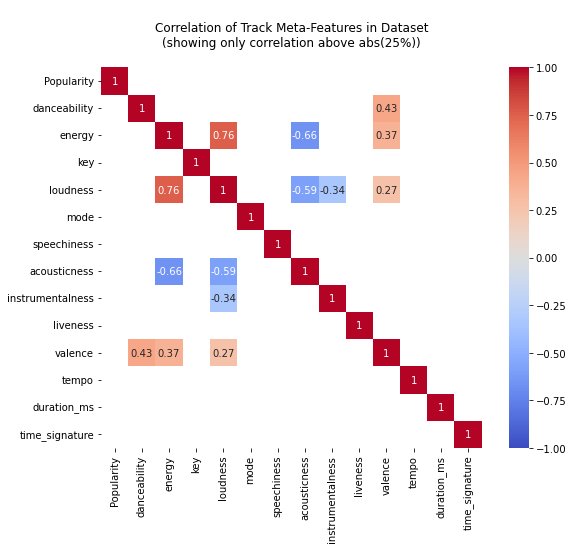

In [24]:
# Correlation graph of features - does this mean anything? haha
list_excl = [col for col in pl_songs_df if col not in ['Available','Explicit']]
mask = np.abs(pl_songs_df[list_excl].corr()) < 0.25

plt.figure(figsize=(10,7))
plt.title('''
Correlation of Track Meta-Features in Dataset
(showing only correlation above abs(25%))
''')
sns.heatmap(pl_songs_df[list_excl].corr(),vmin=-1,vmax=1,cmap='coolwarm',
            square = True, mask = mask, annot=True)

plt.xticks();

### Markers for Recommender Evaluation
1. Mood markers: `danceability`, `energy`, `valence`, `tempo`, `acousticness`, `loudness`
2. Song similarity markers: all mood markers, `speechiness`, `acousticness`, `instrumentalness`, `liveness`
3. Music metadata: `key`, `mode`, `duration_ms`, `time_signature`

Considerations:
1. `Acousticness` is not a direct measure of mood/energy, but in general acoustic songs tend to be lower on the energy scale. This is represented by a strong inverse correlation with `loudness` and `energy`.
2. `Loudness` too is somewhat representive of mood (*high energy ~ louder*).
3. `Valence`, according to Spotify's documentation, is "*a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)*".<sup>1</sup>  
`Valence` is loosely correlated to `danceability`, `energy`, and `loudness`.

4. Music metadata is generally unuseful for the recommender engine; `key`/`mode`/`duration_ms`/ `time_signature` are not really related to the *feel* of a song, just its composition. The one niche exception would be `duration_ms`, since in particular looking for radio-edit songs means you can reasonably assume the songs you want are below a certin duration (*most radio shows have a softcap of around 3mins per song*). This is however more useful as a censor than as a metric. For the scope of this project, the duration will be left out.
5. Song similarity markers are important too, as they tell us how similar each **consecutive** song is to the previous/next one.

<sup>1</sup> Testing this by filling a playlist with the highest valence values (and another with the lowest), I find this is somewhat true - although there is also a certain element of nuance to it. If we have learnt anything from Disney's hit animation film "*Inside Out*", emotions are hardly a 1-dimensional spectrum, and oftentimes exist (*and are expressed*) with other emotions concurrently. For e.g., songs in the lowest valence pool tend to be songs with more complicated emotional 'stories'; perhaps descriptors like 'bittersweet' or 'melancholic' would better describe them than just 'sad', and 'excited', 'edgy', or 'provacative' for 'happy'. Still, it does its job as a generalised mood metric.

In [25]:
# Estimated time signature - generally listenable songs are in 3/4 or 4/4
pl_songs_df['time_signature'].unique()

array([3, 4, 5, 1, 0])

In [26]:
# C = 0, Db/C# = 1, etc.; no key detected = -1
pl_songs_df['key'].unique()

array([ 7,  1,  8,  2, 11,  6,  0,  4,  9,  5, 10,  3])

In [27]:
# mode: 1 for major, 0 for minor 
print(f'Major:{len(pl_songs_df[pl_songs_df["mode"] == 1].index)}, Minor:{len(pl_songs_df[pl_songs_df["mode"] == 0].index)}')
pl_songs_df['mode'].unique()

Major:1308, Minor:797


array([1, 0])

### Data Cleaning

#### Removing 'True' Duplicates
Finding 'true' duplicates - we need to consider the following:
1. Songs by different artists with the same name
2. Some songs are re-released on other albums, so will have different unique identifiers

In [28]:
# Remove unique modifiers
unique_tags = ['Popularity','Album','track_href','analysis_url','track_uri','artist_uri','album_uri'] 
songs_dup = pl_songs_df[[col for col in pl_songs_df.columns if col not in unique_tags]].copy()[pl_songs_df.duplicated(subset='Name',keep=False)]
songs_dup[['Artist','Genres']] = songs_dup[['Artist','Genres']].astype(str) # Convert lists into strings

df_no_dup = pl_songs_df.copy().drop(index=songs_dup[songs_dup.duplicated()].index, errors='ignore')

print(f'Number of duplicate entries:{len(songs_dup[songs_dup.duplicated()].index)}')
print(f'Total number of songs after duplicate removal:{df_no_dup.shape[0]}')

Number of duplicate entries:8
Total number of songs after duplicate removal:2097


In [29]:
pl_songs_df = df_no_dup.copy().reset_index()

#### Convert Boolean fields into int
Converting `Available` and `Explicit` boolean features to integer.

`Available` reflects whether the song is available for consumption in a given market that Spotify services, while `Explicit` is a switch tagged to songs with expletives and vulgarities.

This is done for future consideration of the recommender engine, if the model is to be considered for deployment to users in different markets; it is not yet currently useful.

In [30]:
pl_songs_df[['Explicit','Available']] = pl_songs_df[['Explicit','Available']].astype(int)

In [31]:
pl_songs_df[['Explicit','Available']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Explicit   2097 non-null   int64
 1   Available  2097 non-null   int64
dtypes: int64(2)
memory usage: 32.9 KB


### Preprocessing

#### 1. Drop Irrelevant Columns
1. **`Album`**: not that important, as it often contains little information about the song itself.
2. **Music markers**: `key`,`mode`,`time_signature`,`duration_ms`
3. **All uris and urls except for** `track_uri`
4. `Available` **and** `Explicit`

In [32]:
drop_col = ['Name','Album','key','mode','time_signature',
            'duration_ms','track_href','analysis_url','artist_uri',
            'album_uri','type','Available','Explicit']
df_dropped = pl_songs_df[['track_uri']+[col for col in pl_songs_df.columns if col not in drop_col+['track_uri']]]
df_dropped.head()

,track_uri,index,Artist,Genres,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,spotify:track:1c5CllrZr45UBhWpIqM332,0,[Thundercat],[afrofuturism],74,0.586,0.893,-8.772,0.4390,0.8270,0.642000,0.2120,0.650,140.023
1,spotify:track:1bBDwauDhzcOxV0pqHgBey,1,[cero],"[j-rock, japanese alternative rock, japanese i...",34,0.768,0.348,-12.357,0.1390,0.3890,0.740000,0.1210,0.481,87.006
2,spotify:track:1DezS9kjU3DfhRsSzpz8hh,2,[SOIL & “PIMP” SESSIONS],"[japanese jazz, japanese jazz fusion, japanese...",36,0.512,0.565,-6.891,0.0528,0.2320,0.913000,0.1660,0.436,85.893
3,spotify:track:6PDL4t1R5m3kYN2qIumKc1,3,[UNCHAIN],[j-rock],45,0.567,0.924,-3.824,0.0588,0.1070,0.000000,0.3440,0.707,101.934
4,spotify:track:7qOsSOpiL3R8RKyiBtIYNQ,4,[BUMP OF CHICKEN],"[j-pop, j-rock]",75,0.622,0.940,-4.997,0.0413,0.0094,0.000006,0.0957,0.960,158.056


#### 2. Vectorize the Genre Column
Note that only Genre is vectorized, and not Artist/Collaborator names, as trying to gain some insights from the name of bands and artists will only be noise to the model.

As mentioned before, while Genre is not used in the current version of the app, it will be useful for future developments.

In [33]:
df_str = df_dropped.copy()
for col in ['Genres']:
    df_str[col] = [[i.strip() for i in j] for j in df_dropped[col]]
    df_str[col] = [','.join(lst) for lst in df_str[col]]
df_str.shape

(2097, 14)

In [34]:
# Count Vectorizer for Genres
# Binary = True: We only care if it is something, not how many times it appears
cvec1 = CountVectorizer(ngram_range=(1,3), binary = True)
cvec_array_gen = cvec1.fit_transform(df_str['Genres'])

# Temp df
temp = pd.concat([
    # pd.DataFrame(cvec_array_gen.toarray(),columns=cvec1.get_feature_names_out())
    #|-----------------------------------------------------------------------------------|
    # If running version of sklearn < v1.1, need to run this code instead.
    pd.DataFrame(cvec_array_gen.toarray(),columns=cvec1.get_feature_names())
    #|-----------------------------------------------------------------------------------|  
],axis=1).fillna(0).astype(int)


/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
# Opted for Count-Vec + dropping columns <= 1 sum
# Earlier tests suggest that the Tfidf vectorizer regularises too many genre tokens for the vectors to be useful
temp = temp.drop(columns=temp.loc[:,temp.sum() <= 1].columns)

In [36]:
# For genres, having duplicate tokens in each ngram seems like a redundant distinction
duplicates = len(temp.columns)-len(np.unique([str(list(np.unique(i.split(' ')))).replace('[','').replace(']','').replace("'",'').replace(',','')
 for i in temp.columns]))
print(f'There are {duplicates} duplicate columns, considering repeat tokens in n-grams')

There are 434 duplicate columns, considering repeat tokens in n-grams


In [37]:
# Exploiting .duplicated() to remove repeated columns
temp_2 = temp.copy()
temp_2.columns = [str(list(np.unique(i.split(' ')))).replace('[','').replace(']','').replace("'",'').replace(',','')for i in temp.columns]
# temp_2 = temp_2.groupby(axis=1,level=0).sum()
# temp.shape[1] - temp_2.shape[1]
temp_2 = temp_2.loc[:,~temp_2.columns.duplicated()]

In [38]:
# Merging back
df_vectorized=pd.concat((
    df_str[[col for col in df_str.columns if col not in ['Artist','Genres']]],
    temp_2),
    axis=1)
df_vectorized.head()

,track_uri,index,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,coast west,virginia west,indie virginia west,wonky,world,world worship,worship,smooth worship,yacht,rock yacht
0,spotify:track:1c5CllrZr45UBhWpIqM332,0,74,0.586,0.893,-8.772,0.4390,0.8270,0.642000,0.2120,...,0,0,0,0,0,0,0,0,0,0
1,spotify:track:1bBDwauDhzcOxV0pqHgBey,1,34,0.768,0.348,-12.357,0.1390,0.3890,0.740000,0.1210,...,0,0,0,0,0,0,0,0,0,0
2,spotify:track:1DezS9kjU3DfhRsSzpz8hh,2,36,0.512,0.565,-6.891,0.0528,0.2320,0.913000,0.1660,...,0,0,0,0,0,0,0,0,0,0
3,spotify:track:6PDL4t1R5m3kYN2qIumKc1,3,45,0.567,0.924,-3.824,0.0588,0.1070,0.000000,0.3440,...,0,0,0,0,0,0,0,0,0,0
4,spotify:track:7qOsSOpiL3R8RKyiBtIYNQ,4,75,0.622,0.940,-4.997,0.0413,0.0094,0.000006,0.0957,...,0,0,0,0,0,0,0,0,0,0


#### 3. Scaling Our Numerical Features
This is important to give these features equal weightage for the cosine similarity to prioritise each metric individually and equally.

In [39]:
audio_feat_vect = ['Popularity']+[col for col in audio_features if col in df_vectorized.columns]
df_vectorized[audio_feat_vect].head()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,74,0.586,0.893,-8.772,0.4390,0.8270,0.642000,0.2120,0.650,140.023
1,34,0.768,0.348,-12.357,0.1390,0.3890,0.740000,0.1210,0.481,87.006
2,36,0.512,0.565,-6.891,0.0528,0.2320,0.913000,0.1660,0.436,85.893
3,45,0.567,0.924,-3.824,0.0588,0.1070,0.000000,0.3440,0.707,101.934
4,75,0.622,0.940,-4.997,0.0413,0.0094,0.000006,0.0957,0.960,158.056


In [40]:
ss = StandardScaler()
df_varray = ss.fit_transform(df_vectorized[audio_feat_vect])
df_scaled = df_vectorized.copy()
df_scaled[audio_feat_vect] = pd.DataFrame(df_varray,columns=audio_feat_vect)
df_scaled[audio_feat_vect].head()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2.345815,-0.013276,1.504896,0.082686,4.384150,1.603356,1.134214,0.241705,0.657316,0.872581
1,0.503359,1.168074,-1.076726,-0.893590,0.709331,0.167143,1.418901,-0.360095,-0.060800,-0.959218
2,0.595482,-0.493605,-0.048814,0.594925,-0.346567,-0.347665,1.921462,-0.062502,-0.252014,-0.997674
3,1.010034,-0.136604,1.651741,1.430138,-0.273071,-0.757543,-0.730779,1.114644,0.899521,-0.443438
4,2.391876,0.220398,1.727531,1.110704,-0.487436,-1.077576,-0.730760,-0.527408,1.974570,1.495643


#### 4. Creating mood vectors
For now, we take the average of relevant mood vectors (scaled) to get our generic mood vectors. We will need to aggregate some usable vectors from what Spotify provides us with.

Mood markers - a quick recap:   
`danceability` - How danceable a song is (*roughly*).  
`energy` - How exciting/moving the music is.  
`valence` - A measure of positivity of the song (*high emotional valence = more 'happy'-sounding it is*).  
`tempo` - beats-per-minute.  
`acousticness` - How 'stripped down' the instrumentation is - think Ed Sheeran or Jason Mraz.  
`loudness` - decibels  

Considering the following engineered features:  
[1] Impact(mellow/excited)
* a more robust version of `energy`, accounting for `loudness`, `tempo`, and (-ve) `acousticness` 

[2] Hype I can only describe this metric as how 'catchy' some music is`valence`, `energy`, `tempo`, secondaries: `danceability`, `loudness`  
[3] Vibes - mostly `danceability`, but taking into account to a small extent other meta factors like `energy`, absolute `valence` value (standard scaled), and (-ve) `loudness`.

In [41]:
mood_markers=['danceability','energy','loudness','acousticness','valence','tempo']

In [42]:
for i in df_scaled.index:
    # Excitement - arbitrary weights for constituent vectors, based on domain knowledge
    df_scaled.loc[i,'impact'] = np.average(a=(df_scaled.loc[i,'danceability'],
                                                  df_scaled.loc[i,'energy'],
                                                  df_scaled.loc[i,'valence'],
                                                  df_scaled.loc[i,'tempo'],
                                                  df_scaled.loc[i,'acousticness'],
                                                  df_scaled.loc[i,'loudness']),
                                               weights=[0,1,0,0.5,-0.5,1])
    
    # Hype - arbitrary weights for constituent vectors, based on domain knowledge
    df_scaled.loc[i,'hype'] = np.average(a=(df_scaled.loc[i,'danceability'],
                                            df_scaled.loc[i,'energy'],
                                            df_scaled.loc[i,'valence'],
                                            df_scaled.loc[i,'tempo'],
                                            df_scaled.loc[i,'acousticness'],
                                            df_scaled.loc[i,'loudness']),
                                         weights=[0.5,1,1,1,0,0.5])
    
    # Vibes - arbitrary weights for constituent vectors, based on domain knowledge
    df_scaled.loc[i,'vibes'] = np.average(a=(df_scaled.loc[i,'danceability'],
                                             df_scaled.loc[i,'energy'],
                                             # vibe is more to do with intensity, so +/- valence should be considered
                                             np.absolute(df_scaled.loc[i,'valence']), 
                                             df_scaled.loc[i,'tempo'],
                                             df_scaled.loc[i,'acousticness'],
                                             df_scaled.loc[i,'loudness']),
                                          weights=[1,0.2,0.2,0,0,-0.2])

# Scale the new meta-features
ss = StandardScaler()
df_varray = ss.fit_transform(df_scaled[['impact','hype','vibes']])
df_scaled[['impact','hype','vibes']] = pd.DataFrame(df_varray,columns=['impact','hype','vibes'])
    

In [43]:
df_scaled.head()

,track_uri,index,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,wonky,world,world worship,worship,smooth worship,yacht,rock yacht,impact,hype,vibes
0,spotify:track:1c5CllrZr45UBhWpIqM332,0,2.345815,-0.013276,1.504896,0.082686,4.384150,1.603356,1.134214,0.241705,...,0,0,0,0,0,0,0,0.519401,1.269817,0.235696
1,spotify:track:1bBDwauDhzcOxV0pqHgBey,1,0.503359,1.168074,-1.076726,-0.893590,0.709331,0.167143,1.418901,-0.360095,...,0,0,0,0,0,0,0,-1.076670,-0.810624,0.979073
2,spotify:track:1DezS9kjU3DfhRsSzpz8hh,2,0.595482,-0.493605,-0.048814,0.594925,-0.346567,-0.347665,1.921462,-0.062502,...,0,0,0,0,0,0,0,0.093964,-0.516218,-0.742039
3,spotify:track:6PDL4t1R5m3kYN2qIumKc1,3,1.010034,-0.136604,1.651741,1.430138,-0.273071,-0.757543,-0.730779,1.114644,...,0,0,0,0,0,0,0,1.376461,1.139543,-0.080332
4,spotify:track:7qOsSOpiL3R8RKyiBtIYNQ,4,2.391876,0.220398,1.727531,1.110704,-0.487436,-1.077576,-0.730760,-0.527408,...,0,0,0,0,0,0,0,1.752951,2.425579,0.572832


In [44]:
print('Objects in df:')
print(df_scaled.select_dtypes(object).columns)
print('\n')
df_scaled.info()

Objects in df:
Index(['track_uri'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Columns: 1893 entries, track_uri to vibes
dtypes: float64(13), int64(1879), object(1)
memory usage: 30.3+ MB


### Running Cosine Similarity using a test vector
Using cosine similarity (or in more general terms, a distance vector for similarity) seems like the obvious choice in this case, since we are dealing with a content-based filtering model to figure out what the closest songs would be for any given target vector. 

As a brief explanation, cosine similarity is the cosine value of the angle between two vectors (from the origin). This relationship is different from your regular distance metric, as it can be interpreted as the angular relationship between vectors, rather than a distance metric.

Some considerations:
1. Drop columns from the model that are not given a vector; this way the similarity will only consider the inputted values, and thus how close they are in terms of the supplied vectors.
2. While the overall end-goal is to have a model that can use similarity taking into consideration all relevant features, for the purposes of creating a base playlist this is not needed. (thinking about drop features, and genre vectorisation)

In [45]:
# Testing cosine similarity with dummy solve value
test_vector = {'track_uri':'target',
               'impact':0.8,
               'hype':0.55,
               'vibes':0.75,
               'instrumentalness':0.8,
               'speechiness':0.5,
               'acousticness':0.1,
               'danceability':0.9,
               'tempo':0.5,
               'valence':0.5,
               'loudness':0.5,
               'Popularity':0.5
              }
    
# All the target vectors are on a scale from 0 to 1; in other words, we can view these as being the probability density
# of the target point in the scaled df. Hence, we can scale them using an inverse-normal function.

for col in [i for i in test_vector.keys() if i != 'track_uri']:
    test_vector[col] = round(norm.ppf(test_vector[col],loc=df_scaled[col].mean(),scale=df_scaled[col].std()),6)

test_vector

{'track_uri': 'target',
 'impact': 0.841822,
 'hype': 0.125691,
 'vibes': 0.674651,
 'instrumentalness': 0.841822,
 'speechiness': 0.0,
 'acousticness': -1.281857,
 'danceability': 1.281857,
 'tempo': -0.0,
 'valence': -0.0,
 'loudness': 0.0,
 'Popularity': -0.0}

In [46]:
# Adding the target vector to the cosine similarity df
test_df = pd.DataFrame(test_vector,index=[0])

# concat, and fillna with 0 (for standard scaled vectors, 0 should be mean value)
df_test = pd.concat((df_scaled,test_df),ignore_index=True).fillna(0)

df_test[df_test['track_uri'] == 'target']

,track_uri,index,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,wonky,world,world worship,worship,smooth worship,yacht,rock yacht,impact,hype,vibes
2097,target,0.0,-0.0,1.281857,0.0,0.0,0.0,-1.281857,0.841822,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841822,0.125691,0.674651


In [47]:
# Remove unnecessary vectors in the dataframe
df_test = df_test[test_vector.keys()]
df_test[df_test['track_uri'] == 'target']

,track_uri,impact,hype,vibes,instrumentalness,speechiness,acousticness,danceability,tempo,valence,loudness,Popularity
2097,target,0.841822,0.125691,0.674651,0.841822,0.0,-1.281857,1.281857,-0.0,-0.0,0.0,-0.0


In [48]:
# Applying cosine similarity
track_sim = pd.DataFrame(cosine_similarity(df_test.set_index('track_uri')),
                         columns=df_test.set_index('track_uri').index,
                         index=df_test.set_index('track_uri').index)

track_order = track_sim['target'].sort_values(ascending=False).drop(index='target').index
track_order

Index(['spotify:track:3lg1wx9oVqgKGBhR0LcEnS',
       'spotify:track:4YbtSmL1FF13DsMLOB9WtI',
       'spotify:track:3L3JqFvXR2Y2W9LhG1ZjE9',
       'spotify:track:64s75Jxg5DILfpihY7q56H',
       'spotify:track:3uIZbgjJyMLDPJUNd35dO9',
       'spotify:track:58RbrbgD2UpSixuusg8HOa',
       'spotify:track:1HHswJeJE7LgBhjGgWih5O',
       'spotify:track:56519brcLZilMPEMGyHGN7',
       'spotify:track:7jlN4Y7mBLre5VPutkIgtH',
       'spotify:track:3pe5HD6djj11F4cnTqnPqt',
       ...
       'spotify:track:1bFeQVE1JjJFLH3HrGIU3Y',
       'spotify:track:76id999lBj0TnMHTXIDlUO',
       'spotify:track:2Emh5N9FIPPmM2OD4M3tD3',
       'spotify:track:5wgxOnyLvseBkoUPMSD2mN',
       'spotify:track:0bWwyCP50N3IDcbUuiOrXI',
       'spotify:track:7fFBLMq8tiwawU2vtJwrVb',
       'spotify:track:24HAkJDgZLa80KiFjJ62vb',
       'spotify:track:6tqzOYuE3lrNVPDgtF3MjM',
       'spotify:track:5SWDPgL0V0z52CsbvPEOVF',
       'spotify:track:2wIHqsfA7ozyjbU4EoHOv3'],
      dtype='object', name='track_uri', length=2

In [49]:
pl_songs_df.set_index('track_uri').reindex(index=track_order).reset_index().head()

,track_uri,index,Name,Artist,Album,Genres,Popularity,Available,Explicit,danceability,...,liveness,valence,tempo,duration_ms,time_signature,type,track_href,analysis_url,artist_uri,album_uri
0,spotify:track:3lg1wx9oVqgKGBhR0LcEnS,169,Pancake Feet,[Tennyson],Uh Oh!,"[edmonton indie, future bass, vapor soul, vapo...",23,1,0,0.870,...,0.0864,0.563,129.950,178712,4,audio_features,https://api.spotify.com/v1/tracks/3lg1wx9oVqgK...,https://api.spotify.com/v1/audio-analysis/3lg1...,[spotify:artist:3Nb8N20WChM0swo5qWTvm8],spotify:album:5A8W5d7LgK7tuq8UdZJE00
1,spotify:track:4YbtSmL1FF13DsMLOB9WtI,654,By Fire - Vikter Duplaix Remix,"[Hiatus Kaiyote, Vikter Duplaix]","Recalibrations, Vol. 1","[alternative r&b, australian r&b, broken beat,...",22,1,0,0.789,...,0.2460,0.604,128.968,298933,4,audio_features,https://api.spotify.com/v1/tracks/4YbtSmL1FF13...,https://api.spotify.com/v1/audio-analysis/4Ybt...,"[spotify:artist:43JlwunhXm1oqdKyOa2Z9Y, spotif...",spotify:album:7EWi5y6EgXcW1TuW81Y3Yi
2,spotify:track:3L3JqFvXR2Y2W9LhG1ZjE9,175,Magnetar (feat. Adam Deitch & Shaun Martin),"[Mark Lettieri, Adam Deitch, Shaun Martin]",Magnetar (feat. Adam Deitch & Shaun Martin),"[fort worth indie, uk contemporary jazz]",34,1,0,0.721,...,0.0716,0.476,113.024,276293,4,audio_features,https://api.spotify.com/v1/tracks/3L3JqFvXR2Y2...,https://api.spotify.com/v1/audio-analysis/3L3J...,"[spotify:artist:3USL7r0FYOWUiTPQGz3HpP, spotif...",spotify:album:7lE7qB2f0S6IL4aUJjKzA4
3,spotify:track:64s75Jxg5DILfpihY7q56H,1400,South of the River,[Tom Misch],South of the River,"[indie soul, jazz pop]",32,1,0,0.845,...,0.0813,0.466,113.003,269815,4,audio_features,https://api.spotify.com/v1/tracks/64s75Jxg5DIL...,https://api.spotify.com/v1/audio-analysis/64s7...,[spotify:artist:1uiEZYehlNivdK3iQyAbye],spotify:album:4gBMR4WEwK3PIQsgIxtlLC
4,spotify:track:3uIZbgjJyMLDPJUNd35dO9,1395,No Answer,[Tennyson],No Answer,"[edmonton indie, future bass, vapor soul, vapo...",0,1,0,0.759,...,0.3480,0.429,124.955,168960,4,audio_features,https://api.spotify.com/v1/tracks/3uIZbgjJyMLD...,https://api.spotify.com/v1/audio-analysis/3uIZ...,[spotify:artist:3Nb8N20WChM0swo5qWTvm8],spotify:album:00RRsSewqsI8x16KgAd8FY


### Conclusions
The model performs fairly well in generating new playlists from a certain pool, following various mood vectors inputted. 

### Further Considerations and Future Additions
In no order of merit:
1. App cloud deployment
2. Create a playlist that follows a 'mood curve' - Creating interpolated mood vectors between multiple solved mood points
3. Sequencing playlist based on user's liked songs
4. Text-based hype/vibe assignment using NLP models
5. Sequencing based on a song or artist seed
6. Pull from more than one playlist